In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import math

device = 'cuda'

batch_size = 32

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#     transforms.RandomRotation(degrees=(-45, 45)),
#     transforms.ColorJitter(brightness=.5,hue=0.5), # 改变图像的亮度和饱和度
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, pin_memory=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Dense-Net

In [2]:
class Bottleneck(nn.Module):
    def __init__(self, in_channel, growth_rate):
        super().__init__()
        middle_channel = 4*growth_rate
        
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channel),
            nn.ReLU(True),
            nn.Conv2d(in_channel, middle_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(middle_channel),
            nn.ReLU(True),
            nn.Conv2d(middle_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1) # cat on dim 1 
    
class Transition(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channel),
            nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False),
            nn.AvgPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.down_sample(x)
    
class DenseNet(nn.Module):
    def __init__(self, block, blocks_config, growth_rate=12, reduction=0.5, num_classes=100):
        super().__init__()
        
        self.growth_rate = growth_rate
        middle_channel = 2*growth_rate
        self.conv1 = nn.Conv2d(3, middle_channel, kernel_size=3, padding=1, bias=False)
        self.layers = nn.Sequential()
        
        for i in range(len(blocks_config)-1):
            self.layers.add_module("Dense_block_layer_{}".format(i), self.make_dense_block(block, middle_channel, blocks_config[i]))
            middle_channel += growth_rate*blocks_config[i]
            
            out_channel = int(reduction*middle_channel)
            self.layers.add_module("Transition_block_{}".format(i), Transition(middle_channel, out_channel))
            middle_channel = out_channel
            
        self.layers.add_module("Dense_block{}".format(len(blocks_config) - 1), self.make_dense_block(block, middle_channel, blocks_config[len(blocks_config)-1]))
        middle_channel += growth_rate * blocks_config[len(blocks_config) - 1]
        self.layers.add_module('bn', nn.BatchNorm2d(middle_channel))
        self.layers.add_module('relu', nn.ReLU(True))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(middle_channel, num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layers(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    
    def make_dense_block(self, block, in_channel, blocks_config):
        dense_block = nn.Sequential()
        for i in range(blocks_config):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), block(in_channel, self.growth_rate))
            in_channel += self.growth_rate
        return dense_block
    
def DenseNet121():
    return DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=20)

model = DenseNet121().to(device)
criterion = nn.CrossEntropyLoss()
loss_arr = []
acc_arr = []

In [3]:
num_print = 500
epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.001)
sched = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12, 24], gamma=0.1)

In [4]:
%%time

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % num_print == num_print-1:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / num_print:.3f}')
            running_loss = 0.0
    
    correct = 0
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            total_loss += criterion(outputs, labels.to(device))
        loss_arr.append(total_loss.cpu() / len(testloader))
        acc = 100 * correct / total
        acc_arr.append(acc)

    print(f'Accuracy: {acc}% ({correct} / {total}), Loss: {total_loss.cpu() / len(testloader):.3f}')

[1,   500] loss: 4.078
[1,  1000] loss: 3.719
[1,  1500] loss: 3.460
Accuracy: 19.17% (1917 / 10000), Loss: 3.292
[2,   500] loss: 3.168
[2,  1000] loss: 2.912
[2,  1500] loss: 2.702
Accuracy: 31.54% (3154 / 10000), Loss: 2.629
[3,   500] loss: 2.511
[3,  1000] loss: 2.394
[3,  1500] loss: 2.329
Accuracy: 41.1% (4110 / 10000), Loss: 2.184
[4,   500] loss: 2.160
[4,  1000] loss: 2.101
[4,  1500] loss: 2.071
Accuracy: 44.29% (4429 / 10000), Loss: 2.024
[5,   500] loss: 1.939
[5,  1000] loss: 1.905
[5,  1500] loss: 1.878
Accuracy: 49.89% (4989 / 10000), Loss: 1.821
[6,   500] loss: 1.782
[6,  1000] loss: 1.753
[6,  1500] loss: 1.746
Accuracy: 51.41% (5141 / 10000), Loss: 1.780
[7,   500] loss: 1.635
[7,  1000] loss: 1.633
[7,  1500] loss: 1.611
Accuracy: 53.97% (5397 / 10000), Loss: 1.667
[8,   500] loss: 1.536
[8,  1000] loss: 1.538
[8,  1500] loss: 1.509
Accuracy: 55.49% (5549 / 10000), Loss: 1.609
[9,   500] loss: 1.436
[9,  1000] loss: 1.429
[9,  1500] loss: 1.455
Accuracy: 57.86% (57

Text(0.5, 1.0, 'Arr')

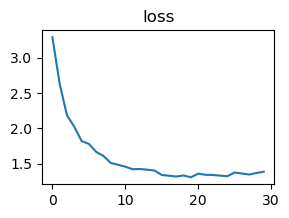

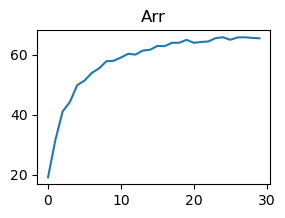

In [8]:
plt.figure(figsize=(3, 2))
plt.plot(loss_arr)
plt.title('loss')

plt.figure(figsize=(3, 2))
plt.plot(acc_arr)
plt.title('Arr')

In [6]:
PATH = './DenseNet.pth'
torch.save(model.state_dict(), PATH)